In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, concatenate, Dense, Flatten, Embedding, Bidirectional, Dropout, GlobalMaxPooling1D, BatchNormalization, SpatialDropout1D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

2024-04-06 11:42:40.828487: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Import dataset
import pandas as pd
from IPython.display import display
from sklearn.utils import shuffle

df = pd.read_csv(r"training_data/IBM30K_shuffled_n.csv")
display(df)
df = shuffle(df).reset_index(drop=True)

attack_count = df[df['relationship'] == "a"].count().iloc[0]
support_count = df[df['relationship'] == "s"].count().iloc[0]
neither_count = df[df['relationship'] == "n"].count().iloc[0]

print(attack_count, support_count, neither_count)

# Split features and labels
X = df[["argument1", "argument2"]].T.reset_index(drop=True).T
y = df[["relationship"]].T.reset_index(drop=True).T

display(X)
display(y)

,Unnamed: 0,argument1,argument2,relationship
0,12014,legalizing the organ trade would make it easie...,We should legalize organ trade,a
1,28303,we should stop urbanization because of the pol...,We should fight urbanization,s
2,10499,it is necessary to provide a safe space for st...,We should abolish safe spaces,a
3,1788,atheism is a concept to adopt because no relig...,We should adopt atheism,s
4,9828,Intelligence tests help people to know recogni...,Intelligence tests bring more harm than good,a
...,...,...,...,...
45541,5108,entrapment enables law enforcement officers to...,Entrapment should be legalized,s
45542,37887,we should adopt libertarianism because people ...,We should prohibit school prayer,n
45543,35183,executive compensation is a reward for those w...,We should abolish the three-strikes laws,n
45544,43857,so many people are over qualified for the jobs...,We should ban missionary work,n


15049 15448 15049


,0,1
0,we need to continue to support economic sancti...,We should ban targeted killing
1,polygamy should be allowed as human beings sho...,Homeschooling should be banned
2,they make people feel inadequate if they mess up.,Intelligence tests bring more harm than good
3,there are already too many guns in the hands o...,We should subsidize space exploration
4,nuclear weapons can eliminate large population...,We should fight for the abolition of nuclear w...
...,...,...
45541,they are cruel to animals and wildlife,We should abolish zoos
45542,affirmative action breeds further resentment t...,We should end affirmative action
45543,the vow of celibacy is as old as time and is a...,Intelligence tests bring more harm than good
45544,"cannabis is a illegal drug for a reason, it is...",We should legalize cannabis


,0
0,n
1,n
2,s
3,n
4,s
...,...
45541,s
45542,s
45543,n
45544,a


In [4]:
# Split train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split pairs of sentences
sentences_train_1 = X_train[0].to_numpy()
sentences_train_2 = X_train[1].to_numpy()

sentences_test_1 = X_test[0].to_numpy()
sentences_test_2 = X_test[1].to_numpy()

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [5]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# prepare target
le = LabelEncoder()
le.fit(np.ravel(y))
y_train_enc = le.transform(np.ravel(y_train))
y_test_enc = le.transform(np.ravel(y_test))
print(y_test_enc)

# one hot encoded
y_train_enc = to_categorical(y_train_enc)
y_test_enc = to_categorical(y_test_enc)

print(y_train_enc, y_test_enc)

[1 2 0 ... 2 2 2]
[[1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]] [[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Flatten features for Glove fitting
texts = np.concatenate([X[0], X[1]])

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
# Encode training data
sequences_train_1 = tokenizer.texts_to_sequences(sentences_train_1)
sequences_train_2 = tokenizer.texts_to_sequences(sentences_train_2)

# Encode testing data
sequences_test_1 = tokenizer.texts_to_sequences(sentences_test_1)
sequences_test_2 = tokenizer.texts_to_sequences(sentences_test_2)

# Padding sequences to have the same length
max_len = 50
print(max_len)

padded_sequences_train_1 = pad_sequences(sequences_train_1, maxlen=max_len, padding='post')
padded_sequences_train_2 = pad_sequences(sequences_train_2, maxlen=max_len, padding='post')

padded_sequences_test_1 = pad_sequences(sequences_test_1, maxlen=max_len, padding='post')
padded_sequences_test_2 = pad_sequences(sequences_test_2, maxlen=max_len, padding='post')

#print(padded_sequences_test_2)

50


In [7]:
from tensorflow.keras.layers import Embedding, Flatten, Dense
import numpy as np
# Load pre-trained GloVe embeddings (you need to download the GloVe file)
glove_embeddings_index = {}
with open('glove/glove.6B.300d.txt', encoding='utf-8') as glove_file:
    for line in glove_file:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove_embeddings_index[word] = coefs

# Create an embedding matrix using GloVe for words in our tokenizer
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 300
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = glove_embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [64]:
# Create input layers
#input_shape = (50, 100)
input_shape = (max_len,)
input1 = Input(shape=input_shape)
input2 = Input(shape=input_shape)

# Create Embedding layer
emb1 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input1)
emb2 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input2)

# Create LSTM layers
lstm1 = LSTM(units=128, return_sequences=True)(emb1)
lstm2 = LSTM(units=128, return_sequences=True)(emb2)

dropout1 = Dropout(0.2)(lstm1)
dropout2 = Dropout(0.2)(lstm2)

# Concatenate the outputs of both LSTM layers
concatenated = concatenate([dropout1, dropout2], axis=-1)

# Reduce dimensionality while preserving important features
pooled = GlobalMaxPooling1D()(concatenated)

# Add a Dense layer for further processing
dense_layer = Dense(32, activation='relu')(pooled)

# Add an output layer
output = Dense(3, activation='softmax')(dense_layer)

# Create the model
model = Model(inputs=[input1, input2], outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_25 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 input_26 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 embedding_24 (Embedding)    (None, 50, 300)              4146300   ['input_25[0][0]']            
                                                                                                  
 embedding_25 (Embedding)    (None, 50, 300)              4146300   ['input_26[0][0]']            
                                                                                           

In [ ]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max', 
    min_delta=0.0001,
    patience=5,
    restore_best_weights=True,
)

history = model.fit(
    [padded_sequences_train_1, padded_sequences_train_2], 
    y=y_train_enc, 
    validation_split=0.1,
    batch_size=128,
    epochs=50,
    verbose=1,
    callbacks=[es]
)

Epoch 1/50
257/257 [==============================] - 55s 203ms/step - loss: 0.9874 - accuracy: 0.4785 - val_loss: 0.8311 - val_accuracy: 0.6081
Epoch 2/50
257/257 [==============================] - 54s 209ms/step - loss: 0.6682 - accuracy: 0.7106 - val_loss: 0.5964 - val_accuracy: 0.7574
Epoch 3/50
257/257 [==============================] - 62s 242ms/step - loss: 0.4938 - accuracy: 0.8010 - val_loss: 0.4985 - val_accuracy: 0.8148
Epoch 4/50
257/257 [==============================] - 64s 249ms/step - loss: 0.3994 - accuracy: 0.8436 - val_loss: 0.4316 - val_accuracy: 0.8274
Epoch 5/50
257/257 [==============================] - 65s 254ms/step - loss: 0.3381 - accuracy: 0.8693 - val_loss: 0.4155 - val_accuracy: 0.8375
Epoch 6/50
106/257 [===========>..................] - ETA: 36s - loss: 0.2862 - accuracy: 0.8917

In [ ]:
from sklearn.metrics import classification_report
y_pred = model.predict([padded_sequences_test_1, padded_sequences_test_2], batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

print(classification_report(np.argmax(y_test_enc,axis=1), y_pred_bool))

In [ ]:
results = model.evaluate([padded_sequences_test_1, padded_sequences_test_2], y_test_enc, batch_size=32)
print("test loss, test acc:", results)

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_' + metric])
    plt.title('Training and Validation ' + metric.capitalize())
    plt.show()

# Assuming 'history' is the return value from model.fit()
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [25]:
model.save('../saved_models/IBM_model_full_300_better')

INFO:tensorflow:Assets written to: ../saved_models/IBM_model_full_300_better/assets


INFO:tensorflow:Assets written to: ../saved_models/IBM_model_full_300_better/assets


In [17]:
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
# BASE MODEL

In [6]:
from tensorflow.keras.layers import Embedding, Flatten, Dense
import numpy as np
# Load pre-trained GloVe embeddings (you need to download the GloVe file)
glove_embeddings_index = {}
with open('glove/glove.6B.100d.txt', encoding='utf-8') as glove_file:
    for line in glove_file:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove_embeddings_index[word] = coefs

# Create an embedding matrix using GloVe for words in our tokenizer
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = glove_embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [7]:
input_shape = (max_len,)
input1 = Input(shape=input_shape)
input2 = Input(shape=input_shape)

# Create Embedding layer
emb1 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input1)
emb2 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input2)

# Create LSTM layers
lstm1 = LSTM(units=32, return_sequences=True)(emb1)
lstm2 = LSTM(units=32, return_sequences=True)(emb2)
#lstm1 = Bidirectional(LSTM(units=128, return_sequences=True))(emb1)
#lstm2 = Bidirectional(LSTM(units=128, return_sequences=True))(emb2)

dropout1 = Dropout(0.2)(lstm1)
dropout2 = Dropout(0.2)(lstm2)

# Concatenate the outputs of both LSTM layers
concatenated = concatenate([dropout1, dropout2], axis=-1)

# Reduce dimensionality while preserving important features
pooled = Flatten()(concatenated)

# Add a Dense layer for further processing
dense_layer = Dense(32, activation='relu')(pooled)

# Add an output layer
output = Dense(3, activation='softmax')(dense_layer)

# Create the model
base_model = Model(inputs=[input1, input2], outputs=output)

# Compile the model
base_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
base_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 50, 100)              1382100   ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 50, 100)              1382100   ['input_2[0][0]']             
                                                                                              

In [8]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max', 
    min_delta=0.001,
    patience=3,
    restore_best_weights=True,
)

history = base_model.fit(
    [padded_sequences_train_1, padded_sequences_train_2], 
    y=y_train_enc, 
    validation_split=0.1,
    batch_size=128,
    epochs=50,
    verbose=1,
    callbacks=[es]
)

Epoch 1/50
257/257 [==============================] - 12s 36ms/step - loss: 1.0700 - accuracy: 0.3929 - val_loss: 0.9292 - val_accuracy: 0.5475
Epoch 2/50
257/257 [==============================] - 9s 34ms/step - loss: 0.7938 - accuracy: 0.6377 - val_loss: 0.7047 - val_accuracy: 0.6959
Epoch 3/50
257/257 [==============================] - 8s 33ms/step - loss: 0.6495 - accuracy: 0.7214 - val_loss: 0.6498 - val_accuracy: 0.7269
Epoch 4/50
257/257 [==============================] - 8s 32ms/step - loss: 0.5744 - accuracy: 0.7602 - val_loss: 0.5944 - val_accuracy: 0.7569
Epoch 5/50
257/257 [==============================] - 8s 31ms/step - loss: 0.5225 - accuracy: 0.7828 - val_loss: 0.5745 - val_accuracy: 0.7613
Epoch 6/50
257/257 [==============================] - 8s 31ms/step - loss: 0.4801 - accuracy: 0.8032 - val_loss: 0.5463 - val_accuracy: 0.7736
Epoch 7/50
257/257 [==============================] - 8s 31ms/step - loss: 0.4443 - accuracy: 0.8210 - val_loss: 0.5371 - val_accuracy: 0.772

In [9]:
from sklearn.metrics import classification_report
y_pred = base_model.predict([padded_sequences_test_1, padded_sequences_test_2], batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

print(classification_report(np.argmax(y_test_enc,axis=1), y_pred_bool))

570/570 [==============================] - 2s 3ms/step
{'a': 0, 'n': 1, 's': 2}
              precision    recall  f1-score   support

           0       0.79      0.79      0.79      3003
           1       0.88      0.86      0.87      3024
           2       0.78      0.80      0.79      3083

    accuracy                           0.82      9110
   macro avg       0.82      0.82      0.82      9110
weighted avg       0.82      0.82      0.82      9110



In [10]:
# BASE MODEL WITH 300D GLOVE

In [11]:
from tensorflow.keras.layers import Embedding, Flatten, Dense
import numpy as np
# Load pre-trained GloVe embeddings (you need to download the GloVe file)
glove_embeddings_index = {}
with open('glove/glove.6B.300d.txt', encoding='utf-8') as glove_file:
    for line in glove_file:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove_embeddings_index[word] = coefs

# Create an embedding matrix using GloVe for words in our tokenizer
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 300
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = glove_embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [12]:
input_shape = (max_len,)
input1 = Input(shape=input_shape)
input2 = Input(shape=input_shape)

# Create Embedding layer
emb1 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input1)
emb2 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input2)

# Create LSTM layers
lstm1 = LSTM(units=32, return_sequences=True)(emb1)
lstm2 = LSTM(units=32, return_sequences=True)(emb2)
#lstm1 = Bidirectional(LSTM(units=128, return_sequences=True))(emb1)
#lstm2 = Bidirectional(LSTM(units=128, return_sequences=True))(emb2)

dropout1 = Dropout(0.2)(lstm1)
dropout2 = Dropout(0.2)(lstm2)

# Concatenate the outputs of both LSTM layers
concatenated = concatenate([dropout1, dropout2], axis=-1)

# Reduce dimensionality while preserving important features
pooled = Flatten()(concatenated)

# Add a Dense layer for further processing
dense_layer = Dense(32, activation='relu')(pooled)

# Add an output layer
output = Dense(3, activation='softmax')(dense_layer)

# Create the model
model = Model(inputs=[input1, input2], outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 50, 300)              4146300   ['input_3[0][0]']             
                                                                                                  
 embedding_3 (Embedding)     (None, 50, 300)              4146300   ['input_4[0][0]']             
                                                                                            

In [13]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max', 
    min_delta=0.001,
    patience=3,
    restore_best_weights=True,
)

history = model.fit(
    [padded_sequences_train_1, padded_sequences_train_2], 
    y=y_train_enc, 
    validation_split=0.1,
    batch_size=128,
    epochs=50,
    verbose=1,
    callbacks=[es]
)

Epoch 1/50
257/257 [==============================] - 14s 46ms/step - loss: 0.9828 - accuracy: 0.4834 - val_loss: 0.7997 - val_accuracy: 0.6482
Epoch 2/50
257/257 [==============================] - 11s 43ms/step - loss: 0.7154 - accuracy: 0.6928 - val_loss: 0.6693 - val_accuracy: 0.7209
Epoch 3/50
257/257 [==============================] - 11s 43ms/step - loss: 0.5744 - accuracy: 0.7652 - val_loss: 0.5744 - val_accuracy: 0.7588
Epoch 4/50
257/257 [==============================] - 11s 42ms/step - loss: 0.4871 - accuracy: 0.8038 - val_loss: 0.5266 - val_accuracy: 0.7890
Epoch 5/50
257/257 [==============================] - 11s 43ms/step - loss: 0.4315 - accuracy: 0.8272 - val_loss: 0.5023 - val_accuracy: 0.7994
Epoch 6/50
257/257 [==============================] - 11s 43ms/step - loss: 0.3890 - accuracy: 0.8469 - val_loss: 0.4801 - val_accuracy: 0.8126
Epoch 7/50
257/257 [==============================] - 11s 44ms/step - loss: 0.3521 - accuracy: 0.8616 - val_loss: 0.4788 - val_accuracy:

In [14]:
from sklearn.metrics import classification_report
y_pred = model.predict([padded_sequences_test_1, padded_sequences_test_2], batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

print(classification_report(np.argmax(y_test_enc,axis=1), y_pred_bool))

570/570 [==============================] - 3s 5ms/step
{'a': 0, 'n': 1, 's': 2}
              precision    recall  f1-score   support

           0       0.78      0.83      0.80      3003
           1       0.91      0.84      0.87      3024
           2       0.80      0.81      0.81      3083

    accuracy                           0.83      9110
   macro avg       0.83      0.83      0.83      9110
weighted avg       0.83      0.83      0.83      9110



In [15]:
# BASE MODEL WITH 300D GLOVE + 128D LSTM

In [16]:
input_shape = (max_len,)
input1 = Input(shape=input_shape)
input2 = Input(shape=input_shape)

# Create Embedding layer
emb1 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input1)
emb2 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input2)

# Create LSTM layers
lstm1 = LSTM(units=128, return_sequences=True)(emb1)
lstm2 = LSTM(units=128, return_sequences=True)(emb2)
#lstm1 = Bidirectional(LSTM(units=128, return_sequences=True))(emb1)
#lstm2 = Bidirectional(LSTM(units=128, return_sequences=True))(emb2)

dropout1 = Dropout(0.2)(lstm1)
dropout2 = Dropout(0.2)(lstm2)

# Concatenate the outputs of both LSTM layers
concatenated = concatenate([dropout1, dropout2], axis=-1)

# Reduce dimensionality while preserving important features
pooled = Flatten()(concatenated)

# Add a Dense layer for further processing
dense_layer = Dense(32, activation='relu')(pooled)

# Add an output layer
output = Dense(3, activation='softmax')(dense_layer)

# Create the model
model = Model(inputs=[input1, input2], outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 embedding_4 (Embedding)     (None, 50, 300)              4146300   ['input_5[0][0]']             
                                                                                                  
 embedding_5 (Embedding)     (None, 50, 300)              4146300   ['input_6[0][0]']             
                                                                                            

In [17]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max', 
    min_delta=0.001,
    patience=3,
    restore_best_weights=True,
)

history = model.fit(
    [padded_sequences_train_1, padded_sequences_train_2], 
    y=y_train_enc, 
    validation_split=0.1,
    batch_size=128,
    epochs=50,
    verbose=1,
    callbacks=[es]
)

Epoch 1/50
257/257 [==============================] - 41s 150ms/step - loss: 1.0166 - accuracy: 0.4455 - val_loss: 0.8800 - val_accuracy: 0.5980
Epoch 2/50
257/257 [==============================] - 44s 169ms/step - loss: 0.6711 - accuracy: 0.7111 - val_loss: 0.5907 - val_accuracy: 0.7569
Epoch 3/50
257/257 [==============================] - 39s 151ms/step - loss: 0.4893 - accuracy: 0.8022 - val_loss: 0.5295 - val_accuracy: 0.7912
Epoch 4/50
257/257 [==============================] - 39s 153ms/step - loss: 0.3907 - accuracy: 0.8470 - val_loss: 0.4727 - val_accuracy: 0.8139
Epoch 5/50
257/257 [==============================] - 39s 153ms/step - loss: 0.3220 - accuracy: 0.8773 - val_loss: 0.4659 - val_accuracy: 0.8211
Epoch 6/50
257/257 [==============================] - 38s 148ms/step - loss: 0.2609 - accuracy: 0.9015 - val_loss: 0.4668 - val_accuracy: 0.8279
Epoch 7/50
257/257 [==============================] - 37s 144ms/step - loss: 0.2147 - accuracy: 0.9225 - val_loss: 0.4757 - val_ac

In [18]:
from sklearn.metrics import classification_report
y_pred = model.predict([padded_sequences_test_1, padded_sequences_test_2], batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

print(classification_report(np.argmax(y_test_enc,axis=1), y_pred_bool))

570/570 [==============================] - 6s 10ms/step
{'a': 0, 'n': 1, 's': 2}
              precision    recall  f1-score   support

           0       0.78      0.86      0.82      3003
           1       0.90      0.84      0.87      3024
           2       0.82      0.80      0.81      3083

    accuracy                           0.83      9110
   macro avg       0.84      0.83      0.83      9110
weighted avg       0.84      0.83      0.83      9110



In [19]:
# BASE MODEL + 300D GLOVE + 128D LSTM + 1DPOOLING & l2

In [20]:
# Create input layers
#input_shape = (50, 100)
input_shape = (max_len,)
input1 = Input(shape=input_shape)
input2 = Input(shape=input_shape)

# Create Embedding layer
emb1 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input1)
emb2 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input2)

# Create LSTM layers
lstm1 = LSTM(units=128, return_sequences=True)(emb1)
lstm2 = LSTM(units=128, return_sequences=True)(emb2)
#lstm1 = Bidirectional(LSTM(units=128, return_sequences=True))(emb1)
#lstm2 = Bidirectional(LSTM(units=128, return_sequences=True))(emb2)

dropout1 = Dropout(0.2)(lstm1)
dropout2 = Dropout(0.2)(lstm2)

# Concatenate the outputs of both LSTM layers
concatenated = concatenate([dropout1, dropout2], axis=-1)

# Reduce dimensionality while preserving important features
pooled = GlobalMaxPooling1D()(concatenated)

# Add a Dense layer for further processing
dense_layer = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(pooled)

# Add an output layer
output = Dense(3, activation='softmax')(dense_layer)

# Create the model
model = Model(inputs=[input1, input2], outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 input_8 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 embedding_6 (Embedding)     (None, 50, 300)              4146300   ['input_7[0][0]']             
                                                                                                  
 embedding_7 (Embedding)     (None, 50, 300)              4146300   ['input_8[0][0]']             
                                                                                            

In [21]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max', 
    min_delta=0.001,
    patience=3,
    restore_best_weights=True,
)

history = model.fit(
    [padded_sequences_train_1, padded_sequences_train_2], 
    y=y_train_enc, 
    validation_split=0.1,
    batch_size=128,
    epochs=50,
    verbose=1,
    callbacks=[es]
)

Epoch 1/50
257/257 [==============================] - 39s 142ms/step - loss: 1.1758 - accuracy: 0.4545 - val_loss: 0.9363 - val_accuracy: 0.5746
Epoch 2/50
257/257 [==============================] - 49s 191ms/step - loss: 0.8288 - accuracy: 0.6425 - val_loss: 0.7506 - val_accuracy: 0.6932
Epoch 3/50
257/257 [==============================] - 37s 145ms/step - loss: 0.6723 - accuracy: 0.7257 - val_loss: 0.6700 - val_accuracy: 0.7445
Epoch 4/50
257/257 [==============================] - 36s 140ms/step - loss: 0.5927 - accuracy: 0.7659 - val_loss: 0.6345 - val_accuracy: 0.7387
Epoch 5/50
257/257 [==============================] - 36s 142ms/step - loss: 0.5409 - accuracy: 0.7931 - val_loss: 0.5904 - val_accuracy: 0.7733
Epoch 6/50
257/257 [==============================] - 37s 142ms/step - loss: 0.4959 - accuracy: 0.8169 - val_loss: 0.5951 - val_accuracy: 0.7862
Epoch 7/50
257/257 [==============================] - 37s 143ms/step - loss: 0.4510 - accuracy: 0.8430 - val_loss: 0.5475 - val_ac

In [22]:
from sklearn.metrics import classification_report
y_pred = model.predict([padded_sequences_test_1, padded_sequences_test_2], batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

print(classification_report(np.argmax(y_test_enc,axis=1), y_pred_bool))

570/570 [==============================] - 6s 10ms/step
{'a': 0, 'n': 1, 's': 2}
              precision    recall  f1-score   support

           0       0.78      0.82      0.80      3003
           1       0.90      0.81      0.85      3024
           2       0.78      0.83      0.80      3083

    accuracy                           0.82      9110
   macro avg       0.82      0.82      0.82      9110
weighted avg       0.82      0.82      0.82      9110



In [23]:
# BASE MODEL + 300D GLOVE + 128D BiLSTM

In [24]:
input_shape = (max_len,)
input1 = Input(shape=input_shape)
input2 = Input(shape=input_shape)

# Create Embedding layer
emb1 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input1)
emb2 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input2)

# Create LSTM layers
#lstm1 = LSTM(units=128, return_sequences=True)(emb1)
#lstm2 = LSTM(units=128, return_sequences=True)(emb2)
lstm1 = Bidirectional(LSTM(units=128, return_sequences=True))(emb1)
lstm2 = Bidirectional(LSTM(units=128, return_sequences=True))(emb2)

dropout1 = Dropout(0.2)(lstm1)
dropout2 = Dropout(0.2)(lstm2)

# Concatenate the outputs of both LSTM layers
concatenated = concatenate([dropout1, dropout2], axis=-1)

# Reduce dimensionality while preserving important features
pooled = Flatten()(concatenated)

# Add a Dense layer for further processing
dense_layer = Dense(32, activation='relu')(pooled)

# Add an output layer
output = Dense(3, activation='softmax')(dense_layer)

# Create the model
model = Model(inputs=[input1, input2], outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 input_10 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 embedding_8 (Embedding)     (None, 50, 300)              4146300   ['input_9[0][0]']             
                                                                                                  
 embedding_9 (Embedding)     (None, 50, 300)              4146300   ['input_10[0][0]']            
                                                                                            

In [25]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max', 
    min_delta=0.001,
    patience=3,
    restore_best_weights=True,
)

history = model.fit(
    [padded_sequences_train_1, padded_sequences_train_2], 
    y=y_train_enc, 
    validation_split=0.1,
    batch_size=128,
    epochs=50,
    verbose=1,
    callbacks=[es]
)

Epoch 1/50
257/257 [==============================] - 77s 285ms/step - loss: 1.0555 - accuracy: 0.4199 - val_loss: 0.9737 - val_accuracy: 0.4844
Epoch 2/50
257/257 [==============================] - 73s 283ms/step - loss: 0.7979 - accuracy: 0.6312 - val_loss: 0.6771 - val_accuracy: 0.7132
Epoch 3/50
257/257 [==============================] - 73s 284ms/step - loss: 0.5304 - accuracy: 0.7846 - val_loss: 0.5204 - val_accuracy: 0.7923
Epoch 4/50
257/257 [==============================] - 77s 301ms/step - loss: 0.3857 - accuracy: 0.8499 - val_loss: 0.4683 - val_accuracy: 0.8183
Epoch 5/50
257/257 [==============================] - 75s 290ms/step - loss: 0.2900 - accuracy: 0.8911 - val_loss: 0.4698 - val_accuracy: 0.8249
Epoch 6/50
257/257 [==============================] - 74s 287ms/step - loss: 0.2192 - accuracy: 0.9207 - val_loss: 0.4870 - val_accuracy: 0.8315
Epoch 7/50
257/257 [==============================] - 74s 287ms/step - loss: 0.1571 - accuracy: 0.9443 - val_loss: 0.5178 - val_ac

In [26]:
from sklearn.metrics import classification_report
y_pred = model.predict([padded_sequences_test_1, padded_sequences_test_2], batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

print(classification_report(np.argmax(y_test_enc,axis=1), y_pred_bool))

570/570 [==============================] - 10s 16ms/step
{'a': 0, 'n': 1, 's': 2}
              precision    recall  f1-score   support

           0       0.81      0.82      0.82      3003
           1       0.88      0.87      0.87      3024
           2       0.82      0.82      0.82      3083

    accuracy                           0.84      9110
   macro avg       0.84      0.84      0.84      9110
weighted avg       0.84      0.84      0.84      9110



In [27]:
# BASE MODEL + 300D GLOVE + 128D LSTM

In [28]:
input_shape = (max_len,)
input1 = Input(shape=input_shape)
input2 = Input(shape=input_shape)

# Create Embedding layer
emb1 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input1)
emb2 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input2)

# Create LSTM layers
lstm1 = LSTM(units=128, return_sequences=True)(emb1)
lstm2 = LSTM(units=128, return_sequences=True)(emb2)
#lstm1 = Bidirectional(LSTM(units=128, return_sequences=True))(emb1)
#lstm2 = Bidirectional(LSTM(units=128, return_sequences=True))(emb2)

dropout1 = Dropout(0.2)(lstm1)
dropout2 = Dropout(0.2)(lstm2)

# Concatenate the outputs of both LSTM layers
concatenated = concatenate([dropout1, dropout2], axis=-1)

# Reduce dimensionality while preserving important features
pooled = Flatten()(concatenated)

# Add a Dense layer for further processing
dense_layer = Dense(32, activation='relu')(pooled)

# Add an output layer
output = Dense(3, activation='softmax')(dense_layer)

# Create the model
model = Model(inputs=[input1, input2], outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 input_12 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 embedding_10 (Embedding)    (None, 50, 300)              4146300   ['input_11[0][0]']            
                                                                                                  
 embedding_11 (Embedding)    (None, 50, 300)              4146300   ['input_12[0][0]']            
                                                                                            

In [29]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max', 
    min_delta=0.001,
    patience=3,
    restore_best_weights=True,
)

history = model.fit(
    [padded_sequences_train_1, padded_sequences_train_2], 
    y=y_train_enc, 
    validation_split=0.1,
    batch_size=128,
    epochs=50,
    verbose=1,
    callbacks=[es]
)

Epoch 1/50
257/257 [==============================] - 43s 160ms/step - loss: 0.9052 - accuracy: 0.5474 - val_loss: 0.7011 - val_accuracy: 0.6924
Epoch 2/50
257/257 [==============================] - 37s 143ms/step - loss: 0.6013 - accuracy: 0.7453 - val_loss: 0.5587 - val_accuracy: 0.7643
Epoch 3/50
257/257 [==============================] - 36s 141ms/step - loss: 0.4586 - accuracy: 0.8138 - val_loss: 0.4847 - val_accuracy: 0.8071
Epoch 4/50
257/257 [==============================] - 36s 141ms/step - loss: 0.3726 - accuracy: 0.8524 - val_loss: 0.4683 - val_accuracy: 0.8159
Epoch 5/50
257/257 [==============================] - 37s 142ms/step - loss: 0.3095 - accuracy: 0.8805 - val_loss: 0.4382 - val_accuracy: 0.8304
Epoch 6/50
257/257 [==============================] - 36s 141ms/step - loss: 0.2478 - accuracy: 0.9071 - val_loss: 0.4482 - val_accuracy: 0.8312
Epoch 7/50
257/257 [==============================] - 36s 141ms/step - loss: 0.2026 - accuracy: 0.9250 - val_loss: 0.4709 - val_ac

In [30]:
from sklearn.metrics import classification_report
y_pred = model.predict([padded_sequences_test_1, padded_sequences_test_2], batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

print(classification_report(np.argmax(y_test_enc,axis=1), y_pred_bool))

570/570 [==============================] - 6s 10ms/step
{'a': 0, 'n': 1, 's': 2}
              precision    recall  f1-score   support

           0       0.80      0.83      0.82      3003
           1       0.87      0.87      0.87      3024
           2       0.83      0.81      0.82      3083

    accuracy                           0.84      9110
   macro avg       0.84      0.84      0.84      9110
weighted avg       0.84      0.84      0.84      9110



In [31]:
# Attention upgraded

In [32]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, Dense, concatenate, Flatten
from tensorflow.keras.models import Model

input_shape = (max_len,)
input1 = Input(shape=input_shape)
input2 = Input(shape=input_shape)

# Create Embedding layer
emb1 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False, mask_zero=True)(input1)
emb2 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False, mask_zero=True)(input2)

# Create LSTM layers
lstm1 = LSTM(units=128, return_sequences=True)(emb1)
lstm2 = LSTM(units=128, return_sequences=True)(emb2)

# Dropouts
dropout1 = Dropout(0.2)(lstm1)
dropout2 = Dropout(0.2)(lstm2)

# Concatenate the attended outputs
concatenated = concatenate([dropout1, dropout2], axis=-1)

# Reduce dimensionality while preserving important features
flat = Flatten()(concatenated)

# Instead of flattening, feed the concatenated attended outputs directly to the dense layer
dense_layer = Dense(32, activation='relu')(flat)

# Add an output layer
output = Dense(3, activation='softmax')(dense_layer)

# Create the model
model = Model(inputs=[input1, input2], outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 input_14 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 embedding_12 (Embedding)    (None, 50, 300)              4146300   ['input_13[0][0]']            
                                                                                                  
 embedding_13 (Embedding)    (None, 50, 300)              4146300   ['input_14[0][0]']            
                                                                                            

In [33]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max', 
    min_delta=0.001,
    patience=3,
    restore_best_weights=True,
)

history = model.fit(
    [padded_sequences_train_1, padded_sequences_train_2], 
    y=y_train_enc, 
    validation_split=0.1,
    batch_size=128,
    epochs=50,
    verbose=1,
    callbacks=[es]
)

Epoch 1/50
257/257 [==============================] - 45s 158ms/step - loss: 1.1013 - accuracy: 0.3390 - val_loss: 1.0987 - val_accuracy: 0.3337
Epoch 2/50
257/257 [==============================] - 38s 146ms/step - loss: 1.0985 - accuracy: 0.3400 - val_loss: 1.0987 - val_accuracy: 0.3337
Epoch 3/50
257/257 [==============================] - 38s 147ms/step - loss: 1.0739 - accuracy: 0.3780 - val_loss: 1.0308 - val_accuracy: 0.4295
Epoch 4/50
257/257 [==============================] - 38s 149ms/step - loss: 0.9522 - accuracy: 0.4922 - val_loss: 0.8729 - val_accuracy: 0.5738
Epoch 5/50
257/257 [==============================] - 41s 158ms/step - loss: 0.7689 - accuracy: 0.6429 - val_loss: 0.7171 - val_accuracy: 0.6770
Epoch 6/50
257/257 [==============================] - 43s 166ms/step - loss: 0.5957 - accuracy: 0.7427 - val_loss: 0.5792 - val_accuracy: 0.7615
Epoch 7/50
257/257 [==============================] - 41s 159ms/step - loss: 0.4662 - accuracy: 0.8147 - val_loss: 0.5052 - val_ac

In [34]:
from sklearn.metrics import classification_report
y_pred = model.predict([padded_sequences_test_1, padded_sequences_test_2], batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

print(classification_report(np.argmax(y_test_enc,axis=1), y_pred_bool))

570/570 [==============================] - 7s 10ms/step
{'a': 0, 'n': 1, 's': 2}
              precision    recall  f1-score   support

           0       0.80      0.79      0.79      3003
           1       0.90      0.83      0.86      3024
           2       0.77      0.84      0.80      3083

    accuracy                           0.82      9110
   macro avg       0.82      0.82      0.82      9110
weighted avg       0.82      0.82      0.82      9110



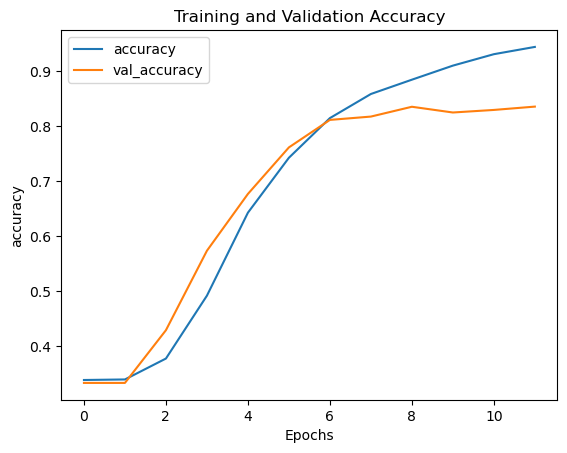

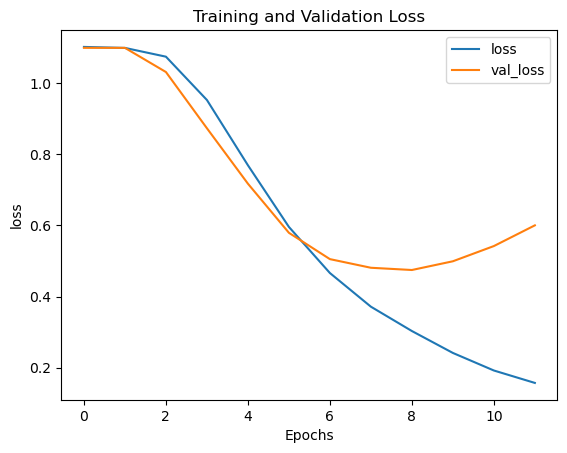

In [35]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_' + metric])
    plt.title('Training and Validation ' + metric.capitalize())
    plt.show()

# Assuming 'history' is the return value from model.fit()
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [36]:
# Attention + BiLSTM

In [37]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, Dense, concatenate, Flatten
from tensorflow.keras.models import Model

input_shape = (max_len,)
input1 = Input(shape=input_shape)
input2 = Input(shape=input_shape)

# Create Embedding layer
emb1 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False, mask_zero=True)(input1)
emb2 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False, mask_zero=True)(input2)

# Create LSTM layers
lstm1 = Bidirectional(LSTM(units=128, return_sequences=True))(emb1)
lstm2 = Bidirectional(LSTM(units=128, return_sequences=True))(emb2)

# Dropouts
dropout1 = Dropout(0.2)(lstm1)
dropout2 = Dropout(0.2)(lstm2)

# Concatenate the attended outputs
concatenated = concatenate([dropout1, dropout2], axis=-1)

# Reduce dimensionality while preserving important features
flat = Flatten()(concatenated)

# Instead of flattening, feed the concatenated attended outputs directly to the dense layer
dense_layer = Dense(32, activation='relu')(flat)

# Add an output layer
output = Dense(3, activation='softmax')(dense_layer)

# Create the model
model = Model(inputs=[input1, input2], outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 input_16 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 embedding_14 (Embedding)    (None, 50, 300)              4146300   ['input_15[0][0]']            
                                                                                                  
 embedding_15 (Embedding)    (None, 50, 300)              4146300   ['input_16[0][0]']            
                                                                                            

In [38]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max', 
    min_delta=0.001,
    patience=3,
    restore_best_weights=True,
)

history = model.fit(
    [padded_sequences_train_1, padded_sequences_train_2], 
    y=y_train_enc, 
    validation_split=0.1,
    batch_size=128,
    epochs=50,
    verbose=1,
    callbacks=[es]
)

Epoch 1/50
257/257 [==============================] - 102s 362ms/step - loss: 0.9660 - accuracy: 0.4881 - val_loss: 0.7562 - val_accuracy: 0.6641
Epoch 2/50
257/257 [==============================] - 86s 335ms/step - loss: 0.6360 - accuracy: 0.7304 - val_loss: 0.5815 - val_accuracy: 0.7618
Epoch 3/50
257/257 [==============================] - 86s 334ms/step - loss: 0.4762 - accuracy: 0.8066 - val_loss: 0.5107 - val_accuracy: 0.7988
Epoch 4/50
257/257 [==============================] - 80s 312ms/step - loss: 0.3643 - accuracy: 0.8582 - val_loss: 0.4834 - val_accuracy: 0.8087
Epoch 5/50
257/257 [==============================] - 79s 307ms/step - loss: 0.2764 - accuracy: 0.8948 - val_loss: 0.4873 - val_accuracy: 0.8178
Epoch 6/50
257/257 [==============================] - 82s 318ms/step - loss: 0.2124 - accuracy: 0.9217 - val_loss: 0.4998 - val_accuracy: 0.8235
Epoch 7/50
257/257 [==============================] - 85s 332ms/step - loss: 0.1634 - accuracy: 0.9415 - val_loss: 0.5442 - val_a

In [39]:
from sklearn.metrics import classification_report
y_pred = model.predict([padded_sequences_test_1, padded_sequences_test_2], batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

print(classification_report(np.argmax(y_test_enc,axis=1), y_pred_bool))

570/570 [==============================] - 15s 22ms/step
{'a': 0, 'n': 1, 's': 2}
              precision    recall  f1-score   support

           0       0.80      0.84      0.82      3003
           1       0.88      0.85      0.87      3024
           2       0.83      0.82      0.82      3083

    accuracy                           0.84      9110
   macro avg       0.84      0.84      0.84      9110
weighted avg       0.84      0.84      0.84      9110



In [40]:
# BASE MODEL + 300D GLOVE + 256D BiLSTM + max1DPooling + attention

In [54]:
input_shape = (max_len,)
input1 = Input(shape=input_shape)
input2 = Input(shape=input_shape)

# Create Embedding layer
emb1 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False, mask_zero=True)(input1)
emb2 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False, mask_zero=True)(input2)

# Create LSTM layers
#lstm1 = LSTM(units=128, return_sequences=True)(emb1)
#lstm2 = LSTM(units=128, return_sequences=True)(emb2)
lstm1 = Bidirectional(LSTM(units=256, return_sequences=True))(emb1)
lstm2 = Bidirectional(LSTM(units=256, return_sequences=True))(emb2)

dropout1 = Dropout(0.2)(lstm1)
dropout2 = Dropout(0.2)(lstm2)

# Concatenate the outputs of both LSTM layers
concatenated = concatenate([dropout1, dropout2], axis=-1)

# Reduce dimensionality while preserving important features
pooled = GlobalMaxPooling1D()(concatenated)

# Add a Dense layer for further processing
dense_layer = Dense(32, activation='relu')(pooled)

# Add an output layer
output = Dense(3, activation='softmax')(dense_layer)

# Create the model
model = Model(inputs=[input1, input2], outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_25 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 input_26 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 embedding_24 (Embedding)    (None, 50, 300)              4146300   ['input_25[0][0]']            
                                                                                                  
 embedding_25 (Embedding)    (None, 50, 300)              4146300   ['input_26[0][0]']            
                                                                                           

In [55]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max', 
    min_delta=0.001,
    patience=3,
    restore_best_weights=True,
)

history = model.fit(
    [padded_sequences_train_1, padded_sequences_train_2], 
    y=y_train_enc, 
    validation_split=0.1,
    batch_size=128,
    epochs=50,
    verbose=1,
    callbacks=[es]
)

Epoch 1/50
257/257 [==============================] - 203s 739ms/step - loss: 0.9547 - accuracy: 0.5106 - val_loss: 0.7522 - val_accuracy: 0.6866
Epoch 2/50
257/257 [==============================] - 195s 760ms/step - loss: 0.5954 - accuracy: 0.7567 - val_loss: 0.5424 - val_accuracy: 0.7975
Epoch 3/50
257/257 [==============================] - 180s 700ms/step - loss: 0.4518 - accuracy: 0.8227 - val_loss: 0.4575 - val_accuracy: 0.8304
Epoch 4/50
257/257 [==============================] - 185s 721ms/step - loss: 0.3586 - accuracy: 0.8626 - val_loss: 0.4189 - val_accuracy: 0.8389
Epoch 5/50
257/257 [==============================] - 191s 742ms/step - loss: 0.2843 - accuracy: 0.8970 - val_loss: 0.4040 - val_accuracy: 0.8477
Epoch 6/50
257/257 [==============================] - 183s 710ms/step - loss: 0.2278 - accuracy: 0.9189 - val_loss: 0.3920 - val_accuracy: 0.8546
Epoch 7/50
257/257 [==============================] - 188s 730ms/step - loss: 0.1744 - accuracy: 0.9401 - val_loss: 0.3962 -

In [56]:
from sklearn.metrics import classification_report
y_pred = model.predict([padded_sequences_test_1, padded_sequences_test_2], batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

print(classification_report(np.argmax(y_test_enc,axis=1), y_pred_bool))

570/570 [==============================] - 22s 33ms/step
{'a': 0, 'n': 1, 's': 2}
              precision    recall  f1-score   support

           0       0.81      0.86      0.83      3003
           1       0.92      0.87      0.89      3024
           2       0.83      0.83      0.83      3083

    accuracy                           0.85      9110
   macro avg       0.85      0.85      0.85      9110
weighted avg       0.85      0.85      0.85      9110



In [57]:
# Attention P to C

In [45]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, Dense, concatenate, Permute, Reshape, Dot, Activation, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

# Define the P to C attention mechanism
def p_to_c_attention(child, parent):
    # Step 1: Dot product between parent and child sequences to get the attention scores
    attention_scores = Dot(axes=[2, 2])([parent, child])
    
    # Step 2: Apply softmax to get attention distribution
    attention_distribution = Activation('softmax')(attention_scores)
    
    # Step 3: Use the attention distribution to compute weighted sum of parent sequences
    weighted_sum = Dot(axes=[1, 1])([attention_distribution, parent])
    
    return weighted_sum

input_shape = (max_len,)
input1 = Input(shape=input_shape)
input2 = Input(shape=input_shape)

# Create Embedding layer
emb1 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False, mask_zero=True)(input1)
emb2 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False, mask_zero=True)(input2)

# Create LSTM layers
lstm1 = LSTM(units=64, return_sequences=True)(emb1)
lstm2 = LSTM(units=64, return_sequences=True)(emb2)

dropout1 = Dropout(0.2)(lstm1)
dropout2 = Dropout(0.2)(lstm2)

# Apply P to C attention
p_to_c_attended = p_to_c_attention(lstm1, lstm2)
c_to_p_attended = p_to_c_attention(lstm2, lstm1)

# Create LSTM layers
lstm3 = LSTM(units=64, return_sequences=True)(p_to_c_attended)
lstm4 = LSTM(units=64, return_sequences=True)(c_to_p_attended)

# Optionally combine attended output with the original child sequence
combined_sequence = concatenate([lstm3, lstm4])

# Continue with model construction
pooled = GlobalMaxPooling1D()(combined_sequence)

# Add a Dense layer for further processing
dense_layer = Dense(32, activation='relu')(pooled)

# Add an output layer
output = Dense(3, activation='softmax')(dense_layer)

# Create the model
model = Model(inputs=[input1, input2], outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_20 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 input_19 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 embedding_19 (Embedding)    (None, 50, 300)              4146300   ['input_20[0][0]']            
                                                                                                  
 embedding_18 (Embedding)    (None, 50, 300)              4146300   ['input_19[0][0]']            
                                                                                            

In [46]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max', 
    min_delta=0.001,
    patience=3,
    restore_best_weights=True,
)

history = model.fit(
    [padded_sequences_train_1, padded_sequences_train_2], 
    y=y_train_enc, 
    validation_split=0.1,
    batch_size=128,
    epochs=50,
    verbose=1,
    callbacks=[es]
)

Epoch 1/50
256/257 [============================>.] - ETA: 0s - loss: 0.9892 - accuracy: 0.4881

W0000 00:00:1711730080.048560       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2600 num_cores: 12 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 12582912 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
W0000 00:00:1711730080.051396       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2600 num_cores: 12 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } enviro

257/257 [==============================] - 49s 164ms/step - loss: 0.9890 - accuracy: 0.4883 - val_loss: 0.8499 - val_accuracy: 0.6010
Epoch 2/50
257/257 [==============================] - 36s 140ms/step - loss: 0.7376 - accuracy: 0.6742 - val_loss: 0.6887 - val_accuracy: 0.6880
Epoch 3/50
257/257 [==============================] - 34s 133ms/step - loss: 0.5571 - accuracy: 0.7650 - val_loss: 0.5303 - val_accuracy: 0.7783
Epoch 4/50
257/257 [==============================] - 32s 125ms/step - loss: 0.4342 - accuracy: 0.8221 - val_loss: 0.4708 - val_accuracy: 0.8123
Epoch 5/50
257/257 [==============================] - 31s 122ms/step - loss: 0.3565 - accuracy: 0.8579 - val_loss: 0.4526 - val_accuracy: 0.8159
Epoch 6/50
257/257 [==============================] - 31s 121ms/step - loss: 0.3001 - accuracy: 0.8808 - val_loss: 0.4369 - val_accuracy: 0.8332
Epoch 7/50
257/257 [==============================] - 32s 123ms/step - loss: 0.2599 - accuracy: 0.8989 - val_loss: 0.4386 - val_accuracy: 0.8

In [47]:
from sklearn.metrics import classification_report
y_pred = model.predict([padded_sequences_test_1, padded_sequences_test_2], batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

print(classification_report(np.argmax(y_test_enc,axis=1), y_pred_bool))

W0000 00:00:1711730472.146503       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2600 num_cores: 12 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 12582912 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
W0000 00:00:1711730472.146556       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2600 num_cores: 12 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } enviro

570/570 [==============================] - 8s 9ms/step
{'a': 0, 'n': 1, 's': 2}
              precision    recall  f1-score   support

           0       0.81      0.83      0.82      3003
           1       0.90      0.88      0.89      3024
           2       0.82      0.81      0.82      3083

    accuracy                           0.84      9110
   macro avg       0.84      0.84      0.84      9110
weighted avg       0.84      0.84      0.84      9110



In [48]:
# Attention P to C with 2 LSTM 128

In [67]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, Dense, concatenate, Permute, Reshape, Dot, Activation, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

# Define the P to C attention mechanism
def p_to_c_attention(child, parent):
    # Step 1: Dot product between parent and child sequences to get the attention scores
    attention_scores = Dot(axes=[2, 2])([parent, child])
    
    # Step 2: Apply softmax to get attention distribution
    attention_distribution = Activation('softmax')(attention_scores)
    
    # Step 3: Use the attention distribution to compute weighted sum of parent sequences
    weighted_sum = Dot(axes=[1, 1])([attention_distribution, parent])
    
    return weighted_sum

input_shape = (max_len,)
input1 = Input(shape=input_shape)
input2 = Input(shape=input_shape)

# Create Embedding layer
emb1 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False, mask_zero=True)(input1)
emb2 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False, mask_zero=True)(input2)

# Create LSTM layers
lstm1 = LSTM(units=128, return_sequences=True)(emb1)
lstm2 = LSTM(units=128, return_sequences=True)(emb2)

dropout1 = Dropout(0.2)(lstm1)
dropout2 = Dropout(0.2)(lstm2)

# Apply P to C attention
p_to_c_attended = p_to_c_attention(lstm1, lstm2)
c_to_p_attended = p_to_c_attention(lstm2, lstm1)

# Create LSTM layers
lstm3 = LSTM(units=128, return_sequences=True)(p_to_c_attended)
lstm4 = LSTM(units=128, return_sequences=True)(c_to_p_attended)

# Optionally combine attended output with the original child sequence
combined_sequence = concatenate([lstm3, lstm4])

# Continue with model construction
pooled = GlobalMaxPooling1D()(combined_sequence)

# Add a Dense layer for further processing
dense_layer = Dense(32, activation='relu')(pooled)

# Add an output layer
output = Dense(3, activation='softmax')(dense_layer)

# Create the model
model = Model(inputs=[input1, input2], outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_36 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 input_35 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 embedding_35 (Embedding)    (None, 50, 300)              4146300   ['input_36[0][0]']            
                                                                                                  
 embedding_34 (Embedding)    (None, 50, 300)              4146300   ['input_35[0][0]']            
                                                                                           

In [50]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max', 
    min_delta=0.001,
    patience=3,
    restore_best_weights=True,
)

history = model.fit(
    [padded_sequences_train_1, padded_sequences_train_2], 
    y=y_train_enc, 
    validation_split=0.1,
    batch_size=128,
    epochs=50,
    verbose=1,
    callbacks=[es]
)

Epoch 1/50
257/257 [==============================] - ETA: 0s - loss: 0.9526 - accuracy: 0.5077

W0000 00:00:1711730570.975759       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2600 num_cores: 12 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 12582912 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
W0000 00:00:1711730570.975819       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2600 num_cores: 12 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } enviro

257/257 [==============================] - 95s 339ms/step - loss: 0.9526 - accuracy: 0.5077 - val_loss: 0.7817 - val_accuracy: 0.6435
Epoch 2/50
257/257 [==============================] - 92s 360ms/step - loss: 0.6203 - accuracy: 0.7235 - val_loss: 0.5106 - val_accuracy: 0.7846
Epoch 3/50
257/257 [==============================] - 87s 340ms/step - loss: 0.4345 - accuracy: 0.8147 - val_loss: 0.4451 - val_accuracy: 0.8120
Epoch 4/50
257/257 [==============================] - 76s 295ms/step - loss: 0.3450 - accuracy: 0.8574 - val_loss: 0.4174 - val_accuracy: 0.8353
Epoch 5/50
257/257 [==============================] - 76s 296ms/step - loss: 0.2763 - accuracy: 0.8904 - val_loss: 0.4181 - val_accuracy: 0.8389
Epoch 6/50
257/257 [==============================] - 76s 295ms/step - loss: 0.2286 - accuracy: 0.9126 - val_loss: 0.3924 - val_accuracy: 0.8576
Epoch 7/50
257/257 [==============================] - 76s 294ms/step - loss: 0.1901 - accuracy: 0.9282 - val_loss: 0.4433 - val_accuracy: 0.8

In [51]:
from sklearn.metrics import classification_report
y_pred = model.predict([padded_sequences_test_1, padded_sequences_test_2], batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

print(classification_report(np.argmax(y_test_enc,axis=1), y_pred_bool))

W0000 00:00:1711731447.884943       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2600 num_cores: 12 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 12582912 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
W0000 00:00:1711731447.884985       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2600 num_cores: 12 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } enviro

570/570 [==============================] - 12s 17ms/step
{'a': 0, 'n': 1, 's': 2}
              precision    recall  f1-score   support

           0       0.85      0.82      0.83      3003
           1       0.91      0.94      0.92      3024
           2       0.84      0.85      0.84      3083

    accuracy                           0.87      9110
   macro avg       0.87      0.87      0.87      9110
weighted avg       0.87      0.87      0.87      9110



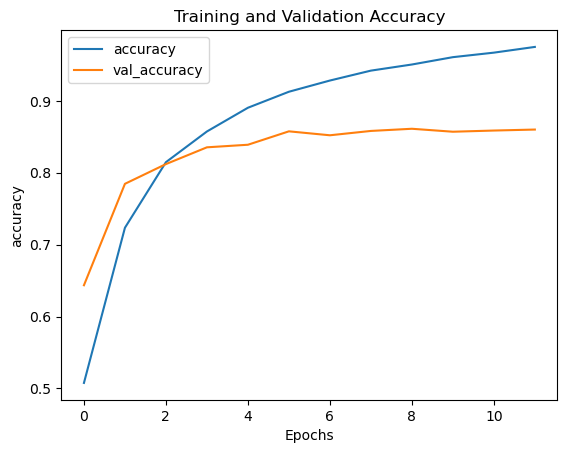

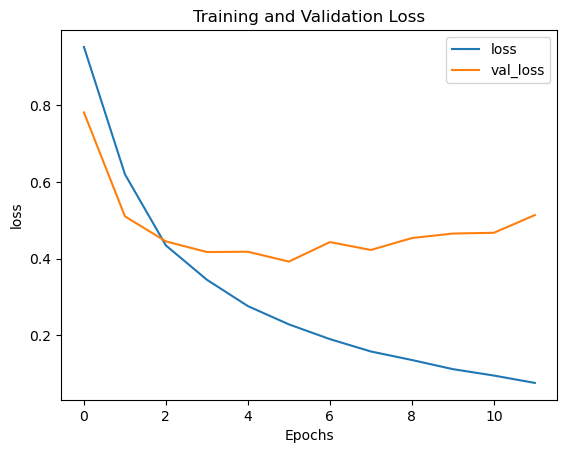

In [52]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_' + metric])
    plt.title('Training and Validation ' + metric.capitalize())
    plt.show()

# Assuming 'history' is the return value from model.fit()
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, Dense, concatenate, Permute, Reshape, Dot, Activation, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

# Define the P to C attention mechanism
def p_to_c_attention(child, parent):
    # Step 1: Dot product between parent and child sequences to get the attention scores
    attention_scores = Dot(axes=[2, 2])([parent, child])
    
    # Step 2: Apply softmax to get attention distribution
    attention_distribution = Activation('softmax')(attention_scores)
    
    # Step 3: Use the attention distribution to compute weighted sum of parent sequences
    weighted_sum = Dot(axes=[1, 1])([attention_distribution, parent])
    
    return weighted_sum

input_shape = (max_len,)
input1 = Input(shape=input_shape)
input2 = Input(shape=input_shape)

# Create Embedding layer
emb1 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False, mask_zero=True)(input1)
emb2 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False, mask_zero=True)(input2)

# Create LSTM layers
lstm1 = Bidirectional(LSTM(units=128, return_sequences=True))(emb1)
lstm2 = Bidirectional(LSTM(units=128, return_sequences=True))(emb2)

dropout1 = Dropout(0.2)(lstm1)
dropout2 = Dropout(0.2)(lstm2)

# Apply P to C attention
p_to_c_attended = p_to_c_attention(dropout1, dropout2)
c_to_p_attended = p_to_c_attention(dropout2, dropout1)

# Create LSTM layers
lstm3 = Bidirectional(LSTM(units=128, return_sequences=True))(p_to_c_attended)
lstm4 = Bidirectional(LSTM(units=128, return_sequences=True))(c_to_p_attended)

# Optionally combine attended output with the original child sequence
combined_sequence = concatenate([lstm3, lstm4])

# Continue with model construction
pooled = GlobalMaxPooling1D()(combined_sequence)

# Add a Dense layer for further processing
dense_layer = Dense(32, activation='relu')(pooled)

# Add an output layer
output = Dense(3, activation='softmax')(dense_layer)

# Create the model
model = Model(inputs=[input1, input2], outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

2024-04-04 15:26:31.042740: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


NameError: name 'max_len' is not defined

In [78]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max', 
    min_delta=0.001,
    patience=3,
    restore_best_weights=True,
)

history = model.fit(
    [padded_sequences_train_1, padded_sequences_train_2], 
    y=y_train_enc, 
    validation_split=0.1,
    batch_size=128,
    epochs=50,
    verbose=1,
    callbacks=[es]
)

Epoch 1/50
257/257 [==============================] - ETA: 0s - loss: 0.9780 - accuracy: 0.4837

W0000 00:00:1711977716.898729       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2600 num_cores: 12 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 12582912 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
W0000 00:00:1711977716.899856       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2600 num_cores: 12 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } enviro

257/257 [==============================] - 210s 758ms/step - loss: 0.9780 - accuracy: 0.4837 - val_loss: 0.7227 - val_accuracy: 0.6721
Epoch 2/50
257/257 [==============================] - 204s 792ms/step - loss: 0.5720 - accuracy: 0.7505 - val_loss: 0.4906 - val_accuracy: 0.7967
Epoch 3/50
257/257 [==============================] - 194s 755ms/step - loss: 0.3960 - accuracy: 0.8343 - val_loss: 0.3825 - val_accuracy: 0.8471
Epoch 4/50
257/257 [==============================] - 186s 722ms/step - loss: 0.3129 - accuracy: 0.8744 - val_loss: 0.3544 - val_accuracy: 0.8584
Epoch 5/50
257/257 [==============================] - 185s 718ms/step - loss: 0.2608 - accuracy: 0.8971 - val_loss: 0.3386 - val_accuracy: 0.8653
Epoch 6/50
257/257 [==============================] - 179s 697ms/step - loss: 0.2182 - accuracy: 0.9168 - val_loss: 0.3372 - val_accuracy: 0.8740
Epoch 7/50
257/257 [==============================] - 179s 695ms/step - loss: 0.1849 - accuracy: 0.9305 - val_loss: 0.3540 - val_accura

In [79]:
from sklearn.metrics import classification_report
y_pred = model.predict([padded_sequences_test_1, padded_sequences_test_2], batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

print(classification_report(np.argmax(y_test_enc,axis=1), y_pred_bool))

W0000 00:00:1711980749.437954       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2600 num_cores: 12 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 12582912 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
W0000 00:00:1711980749.438001       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2600 num_cores: 12 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } enviro

570/570 [==============================] - 24s 34ms/step
{'a': 0, 'n': 1, 's': 2}
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      3003
           1       0.92      0.95      0.93      3024
           2       0.86      0.86      0.86      3083

    accuracy                           0.88      9110
   macro avg       0.88      0.88      0.88      9110
weighted avg       0.88      0.88      0.88      9110



Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_42 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 input_41 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 embedding_41 (Embedding)    (None, 50, 300)              4146300   ['input_42[0][0]']            
                                                                                                  
 embedding_40 (Embedding)    (None, 50, 300)              4146300   ['input_41[0][0]']            
                                                                                           

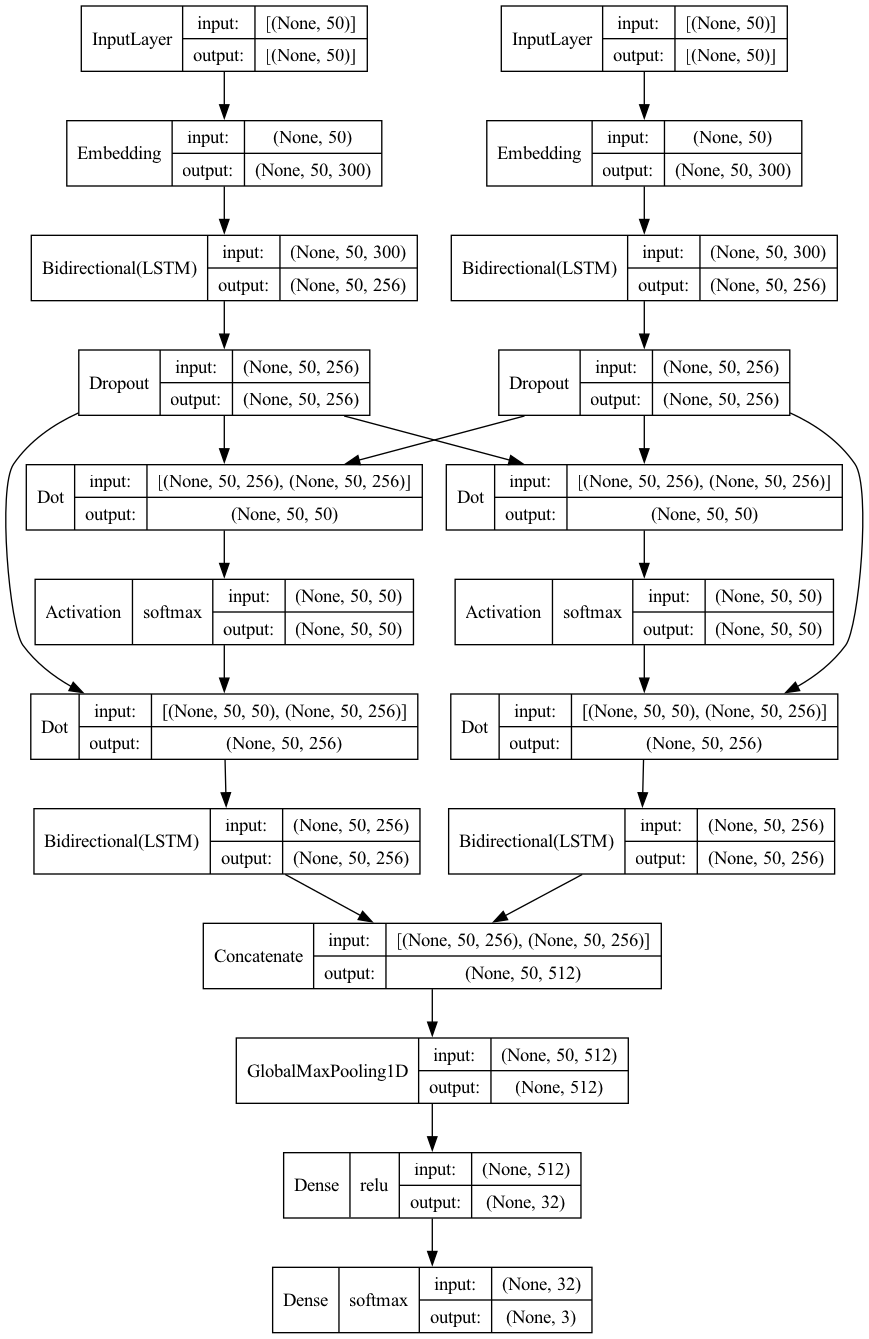

In [83]:
# Show the model architecture
model.summary()
tf.keras.utils.plot_model(model, show_layer_activations=True, show_layer_names=False, show_shapes=True, expand_nested=False)

In [82]:
model.save('../saved_models/IBM_model_final')

INFO:tensorflow:Assets written to: ../saved_models/IBM_model_final/assets


INFO:tensorflow:Assets written to: ../saved_models/IBM_model_final/assets


In [84]:

import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, Dense, concatenate, Permute, Reshape, Dot, Activation, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

# Define the P to C attention mechanism
def p_to_c_attention(child, parent):
    # Step 1: Dot product between parent and child sequences to get the attention scores
    attention_scores = Dot(axes=[2, 2])([parent, child])
    
    # Step 2: Apply softmax to get attention distribution
    attention_distribution = Activation('softmax')(attention_scores)
    
    # Step 3: Use the attention distribution to compute weighted sum of parent sequences
    weighted_sum = Dot(axes=[1, 1])([attention_distribution, parent])
    
    return weighted_sum

input_shape = (max_len,)
input1 = Input(shape=input_shape)
input2 = Input(shape=input_shape)

# Create Embedding layer
emb1 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False, mask_zero=True)(input1)
emb2 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False, mask_zero=True)(input2)

# Create LSTM layers
lstm1 = LSTM(units=128, return_sequences=True)(emb1)
lstm2 = LSTM(units=128, return_sequences=True)(emb2)

dropout1 = Dropout(0.5)(lstm1)
dropout2 = Dropout(0.5)(lstm2)

# Apply P to C attention
p_to_c_attended = p_to_c_attention(dropout1, dropout2)
c_to_p_attended = p_to_c_attention(dropout2, dropout1)

# Create LSTM layers
lstm3 = LSTM(units=128, return_sequences=True)(p_to_c_attended)
lstm4 = LSTM(units=128, return_sequences=True)(c_to_p_attended)

dropout3 = Dropout(0.5)(lstm3)
dropout4 = Dropout(0.5)(lstm4)

# Optionally combine attended output with the original child sequence
combined_sequence = concatenate([dropout3, dropout4])

# Continue with model construction
pooled = GlobalMaxPooling1D()(combined_sequence)

# Add a Dense layer for further processing
dense_layer = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(pooled)

# Add an output layer
output = Dense(3, activation='softmax')(dense_layer)

# Create the model
model = Model(inputs=[input1, input2], outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_44 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 input_43 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 embedding_43 (Embedding)    (None, 50, 300)              4146300   ['input_44[0][0]']            
                                                                                                  
 embedding_42 (Embedding)    (None, 50, 300)              4146300   ['input_43[0][0]']            
                                                                                           

In [85]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max', 
    min_delta=0.01,
    patience=1,
    restore_best_weights=True,
)

history = model.fit(
    [padded_sequences_train_1, padded_sequences_train_2], 
    y=y_train_enc, 
    validation_split=0.1,
    batch_size=128,
    epochs=10,
    verbose=1,
    callbacks=[es]
)

Epoch 1/10
257/257 [==============================] - ETA: 0s - loss: 1.1679 - accuracy: 0.4345

W0000 00:00:1712053279.998987       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2600 num_cores: 12 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 12582912 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
W0000 00:00:1712053279.999159       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2600 num_cores: 12 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } enviro

257/257 [==============================] - 103s 365ms/step - loss: 1.1679 - accuracy: 0.4345 - val_loss: 0.9608 - val_accuracy: 0.6002
Epoch 2/10
257/257 [==============================] - 97s 379ms/step - loss: 0.8077 - accuracy: 0.6567 - val_loss: 0.8362 - val_accuracy: 0.6883
Epoch 3/10
257/257 [==============================] - 135s 527ms/step - loss: 0.6609 - accuracy: 0.7418 - val_loss: 0.7340 - val_accuracy: 0.7604
Epoch 4/10
257/257 [==============================] - 135s 526ms/step - loss: 0.5540 - accuracy: 0.8003 - val_loss: 0.6852 - val_accuracy: 0.7799
Epoch 5/10
257/257 [==============================] - 91s 353ms/step - loss: 0.4761 - accuracy: 0.8354 - val_loss: 0.6269 - val_accuracy: 0.7917
Epoch 6/10
257/257 [==============================] - 92s 356ms/step - loss: 0.4205 - accuracy: 0.8617 - val_loss: 0.5958 - val_accuracy: 0.8208
Epoch 7/10
257/257 [==============================] - 84s 328ms/step - loss: 0.3717 - accuracy: 0.8815 - val_loss: 0.5565 - val_accuracy: 

In [77]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, Dense, concatenate, Permute, Reshape, Dot, Activation, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

# Define the P to C attention mechanism
def p_to_c_attention(child, parent):
    # Step 1: Dot product between parent and child sequences to get the attention scores
    attention_scores = Dot(axes=[2, 2])([parent, child])
    
    # Step 2: Apply softmax to get attention distribution
    attention_distribution = Activation('softmax')(attention_scores)
    
    # Step 3: Use the attention distribution to compute weighted sum of parent sequences
    weighted_sum = Dot(axes=[1, 1])([attention_distribution, parent])
    
    return weighted_sum

input_shape = (max_len,)
input1 = Input(shape=input_shape)
input2 = Input(shape=input_shape)

# Create Embedding layer
emb1 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False, mask_zero=True)(input1)
emb2 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False, mask_zero=True)(input2)

# Create LSTM layers
lstm1 = Bidirectional(LSTM(units=128, return_sequences=True))(emb1)
lstm2 = Bidirectional(LSTM(units=128, return_sequences=True))(emb2)

dropout1 = Dropout(0.2)(lstm1)
dropout2 = Dropout(0.2)(lstm2)

# Apply P to C attention
p_to_c_attended = p_to_c_attention(dropout1, dropout2)
c_to_p_attended = p_to_c_attention(dropout2, dropout1)

# Create LSTM layers
lstm3 = Bidirectional(LSTM(units=128, return_sequences=True))(p_to_c_attended)
lstm4 = Bidirectional(LSTM(units=128, return_sequences=True))(c_to_p_attended)

# Optionally combine attended output with the original child sequence
combined_sequence = concatenate([lstm3, lstm4])

# Continue with model construction
pooled = GlobalMaxPooling1D()(combined_sequence)

# Add a Dense layer for further processing
dense_layer = Dense(32, activation='relu')(pooled)

# Add an output layer
output = Dense(3, activation='softmax')(dense_layer)

# Create the model
model = Model(inputs=[input1, input2], outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_42 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 input_41 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 embedding_41 (Embedding)    (None, 50, 300)              4146300   ['input_42[0][0]']            
                                                                                                  
 embedding_40 (Embedding)    (None, 50, 300)              4146300   ['input_41[0][0]']            
                                                                                           

In [9]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max', 
    min_delta=0.01,
    patience=1,
    restore_best_weights=True,
)

history = model.fit(
    [padded_sequences_train_1, padded_sequences_train_2], 
    y=y_train_enc, 
    validation_split=0.1,
    batch_size=128,
    epochs=10,
    verbose=1,
    callbacks=[es]
)

Epoch 1/10
257/257 [==============================] - 36s 131ms/step - loss: 0.9857 - accuracy: 0.4837 - val_loss: 0.8230 - val_accuracy: 0.6304
Epoch 2/10
257/257 [==============================] - 35s 134ms/step - loss: 0.6335 - accuracy: 0.7333 - val_loss: 0.6101 - val_accuracy: 0.7486
Epoch 3/10
257/257 [==============================] - 36s 141ms/step - loss: 0.4667 - accuracy: 0.8131 - val_loss: 0.5515 - val_accuracy: 0.7777
Epoch 4/10
257/257 [==============================] - 35s 138ms/step - loss: 0.3749 - accuracy: 0.8563 - val_loss: 0.5114 - val_accuracy: 0.8013
Epoch 5/10
257/257 [==============================] - 35s 135ms/step - loss: 0.3053 - accuracy: 0.8849 - val_loss: 0.5134 - val_accuracy: 0.8043
